In [64]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt

Paths


In [ ]:
IMG_SIZE = 256            # input size for the network (square)
BATCH_SIZE = 8
EPOCHS = 10
BASE_DIR = r"C:\\Deep Learning Tasks\\CNN\\CARTOON\\cartoon_dataset"
train_input_dir = os.path.join(BASE_DIR, 'train', 'train_image')
train_target_dir = os.path.join(BASE_DIR, 'train', 'train_cartoon')
val_input_dir   = os.path.join(BASE_DIR, 'validation', 'val_image')
val_target_dir  = os.path.join(BASE_DIR, 'validation', 'val_cartoon')
MODEL_SAVE_PATH = "bestcartoon.keras"
AUTOTUNE = tf.data.AUTOTUNE

In [66]:
def combined_loss(y_true, y_pred):
    # simple MSE (you can add perceptual/SSIM terms later)
    return tf.reduce_mean(tf.square(y_true - y_pred))


In [67]:
def get_image_paths(input_dir, target_dir, exts=("jpg","jpeg","png")):
    # collect all image paths in input_dir and map to target path by filename
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(input_dir, f"*.{ext}")))
    files = sorted(files)
    input_paths = files
    target_paths = [os.path.join(target_dir, os.path.basename(p)) for p in input_paths]
    # filter pairs that actually exist in target_dir
    pairs = [(i,t) for i,t in zip(input_paths, target_paths) if os.path.exists(t)]
    if len(pairs) == 0:
        raise ValueError(f"No matching image pairs found between {input_dir} and {target_dir}.")
    input_paths, target_paths = zip(*pairs)
    return list(input_paths), list(target_paths)

In [68]:
def preprocess_image_pair(inp_path, tgt_path):
    # Read files
    inp = tf.io.read_file(inp_path)
    inp = tf.image.decode_image(inp, channels=3, expand_animations=False)
    inp = tf.image.convert_image_dtype(inp, tf.float32)  # 0..1
    inp = tf.image.resize(inp, [IMG_SIZE, IMG_SIZE])

    tgt = tf.io.read_file(tgt_path)
    tgt = tf.image.decode_image(tgt, channels=3, expand_animations=False)
    tgt = tf.image.convert_image_dtype(tgt, tf.float32)
    tgt = tf.image.resize(tgt, [IMG_SIZE, IMG_SIZE])

    return inp, tgt

In [69]:

def preprocess_image_pair_tf(inp_path_str, tgt_path_str):
    # Pure-TensorFlow implementation for reading (keeps things faster if not using py_function)
    inp = tf.io.read_file(inp_path_str)
    inp = tf.image.decode_image(inp, channels=3, expand_animations=False)
    inp = tf.image.convert_image_dtype(inp, tf.float32)
    inp = tf.image.resize(inp, [IMG_SIZE, IMG_SIZE])

    tgt = tf.io.read_file(tgt_path_str)
    tgt = tf.image.decode_image(tgt, channels=3, expand_animations=False)
    tgt = tf.image.convert_image_dtype(tgt, tf.float32)
    tgt = tf.image.resize(tgt, [IMG_SIZE, IMG_SIZE])
    return inp, tgt


In [70]:
def _py_preproc(a,b):
    # wrapper so tf.py_function returns numpy arrays
    a = a.numpy().decode('utf-8') if isinstance(a, (bytes, np.bytes_)) else str(a)
    b = b.numpy().decode('utf-8') if isinstance(b, (bytes, np.bytes_)) else str(b)
    ia, ta = preprocess_image_pair_tf(a,b)
    return ia, ta

In [71]:
def make_dataset(input_dir, target_dir, batch_size=BATCH_SIZE, shuffle=True):
    inp_paths, tgt_paths = get_image_paths(input_dir, target_dir)

    ds = tf.data.Dataset.from_tensor_slices((inp_paths, tgt_paths))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(inp_paths))

    def load_and_preprocess(inp_path, tgt_path):
        # Decode both
        inp = tf.io.read_file(inp_path)
        inp = tf.image.decode_image(inp, channels=3, expand_animations=False)
        inp = tf.image.convert_image_dtype(inp, tf.float32)
        inp = tf.image.resize(inp, [IMG_SIZE, IMG_SIZE])

        tgt = tf.io.read_file(tgt_path)
        tgt = tf.image.decode_image(tgt, channels=3, expand_animations=False)
        tgt = tf.image.convert_image_dtype(tgt, tf.float32)
        tgt = tf.image.resize(tgt, [IMG_SIZE, IMG_SIZE])

        # Explicitly set shapes (important!)
        inp.set_shape([IMG_SIZE, IMG_SIZE, 3])
        tgt.set_shape([IMG_SIZE, IMG_SIZE, 3])
        return inp, tgt

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [72]:
def build_improved_cartoon_autoencoder(img_size=IMG_SIZE):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(b)

    # Decoder
    u3 = layers.UpSampling2D((2, 2))(b)
    u3 = layers.concatenate([u3, c3])
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(c5)

    u1 = layers.UpSampling2D((2, 2))(c5)
    u1 = layers.concatenate([u1, c1])
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(3, 1, activation='sigmoid', padding='same')(c6)

    model = Model(inputs, outputs, name="improved_cartoon_autoencoder")
    return model


In [73]:
def train():
    # create datasets
    print("Preparing datasets...")
    train_ds = make_dataset(train_input_dir, train_target_dir, batch_size=BATCH_SIZE, shuffle=True)
    val_ds   = make_dataset(val_input_dir, val_target_dir, batch_size=BATCH_SIZE, shuffle=False)

    # build model
    model = build_improved_cartoon_autoencoder()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=combined_loss, metrics=['mse'])
    model.summary()

    # callbacks
    checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss',
                                                    save_best_only=True, save_weights_only=False)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

    # train
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=EPOCHS,
                        callbacks=[checkpoint, reduce_lr, early_stop])

    print("Training finished. Best model saved to:", MODEL_SAVE_PATH)
    return model, history

In [84]:
def cartoonize_postprocess(img, k=8, smooth_strength=0.4, color_preserve=True):
    import cv2, numpy as np
    
    img = np.array(img * 255, dtype=np.uint8)
    smooth = cv2.bilateralFilter(img, d=9, sigmaColor=90, sigmaSpace=90)

    if not color_preserve:
        Z = img.reshape((-1, 3))
        Z = np.float32(Z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        smooth = res.reshape(img.shape)

    dark = cv2.convertScaleAbs(smooth, alpha=1.2, beta=-25)
    return dark.astype(np.uint8) / 255.0


Training 


In [75]:
def enhance_cartoon_realistic_soft_edges(original, cartoon,
                                         line_thin=1,
                                         edge_intensity=0.3,
                                         blur_sigma=0.2,
                                         color_strength=1.2,
                                         blend_with_original=0.6):
    # original and cartoon expected as numpy arrays in range 0..1
    import numpy as np
    if tf.is_tensor(cartoon):
        cartoon = cartoon.numpy()
    if tf.is_tensor(original):
        original = original.numpy()

    cartoon = np.clip(cartoon, 0, 1)
    original = np.clip(original, 0, 1)

    # blend to preserve realistic tones
    cartoon_colored = np.clip(cartoon * (1 - blend_with_original) + original * blend_with_original, 0, 1)

    # detect edges from original image
    gray = cv2.cvtColor((original * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    kernel_size = max(1, int(round(line_thin)))
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    edges_mask = 1 - (edges / 255.0)
    edges_mask = 1 - ((1 - edges_mask) * edge_intensity)
    if blur_sigma > 0:
        # convert to float32 mask for gaussian blur
        edges_mask = cv2.GaussianBlur(edges_mask.astype(np.float32), (0, 0), blur_sigma)

    edges_mask = np.stack([edges_mask]*3, axis=-1)

    # edges slightly darker than inside
    cartoon_with_edges = cartoon_colored * edges_mask

    # boost colors
    cartoon_with_edges = np.clip(cartoon_with_edges * color_strength, 0, 1)

    return cartoon_with_edges

In [76]:
def cartoonify_image(model, img_path):
    # Load original high-res image using PIL via tf / numpy
    from PIL import Image
    orig = Image.open(img_path).convert("RGB")
    orig_w, orig_h = orig.size
    img_resized = orig.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_resized) / 255.0

    input_img = np.expand_dims(img_array, 0).astype(np.float32)
    pred = model.predict(input_img, verbose=0)[0]  # network output in 0..1

    # postprocess (smoothing / quantization)
    pred_pp = cartoonize_postprocess(pred, k=8, color_preserve=True)

    # enhance blending with original to keep realistic tones and soft edges
    enhanced = enhance_cartoon_realistic_soft_edges(original=img_array,
                                                    cartoon=pred_pp,
                                                    line_thin=0.5,
                                                    edge_intensity=0.2,
                                                    blur_sigma=0.2,
                                                    color_strength=1.15,
                                                    blend_with_original=0.7)

    # minor contrast boost
    enhanced = np.clip(enhanced * 1.05, 0, 1)

    # resize back to original resolution
    enhanced_full = cv2.resize((enhanced * 255).astype(np.uint8), (orig_w, orig_h), interpolation=cv2.INTER_CUBIC)
    enhanced_full = enhanced_full.astype(np.float32) / 255.0

    # display
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(np.array(orig)/255.0)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title("Cartoonified")
    plt.imshow(enhanced_full)
    plt.axis('off')
    plt.show()

    return enhanced_full

In [77]:
if __name__ == "__main__":
    # optional: enable GPU growth to avoid OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except:
            pass

    # Train model
    model, history = train()

    # Load best model (ensures combined_loss available)
    model = load_model(MODEL_SAVE_PATH, custom_objects={'combined_loss': combined_loss})

    

Preparing datasets...


Model: "improved_cartoon_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_32[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_34[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_36[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_37[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_38[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 64, 64,    │          0 │ conv2d_39[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d_12… │
│ (Concatenate)       │ 768)              │            │ conv2d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_40[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_13    │ (None, 128, 128,  │          0 │ conv2d_41[0][0] 

 Total params: 7,783,043 (29.69 MB)

 Trainable params: 7,783,043 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1104s 29s/step - loss: 0.0656 - mse: 0.0656 - val_loss: 0.0267 - val_mse: 0.0267 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1476s 39s/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0239 - val_mse: 0.0239 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1162s 31s/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0243 - val_mse: 0.0243 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1346s 36s/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0235 - val_mse: 0.0235 - learning_rate: 0.0010
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1035s 27s/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0232 - val_mse: 0.0232 - learning_rate: 0.0010
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1028s 27s/step - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0230 - val_mse: 0.0230 - learning_rate: 0.0010
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1033s 27s/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0231 - val_mse: 0.0231 - learning_rate: 0.0010

In [ ]:
model.save('cartoon_model.keras')

In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Paste your enhance_cartoon_effect() function here ---

def enhance_cartoon_effect(image, line_thickness=1, color_simplify_level=8):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) if image.shape[-1] == 3 else image.copy()
    color_simplified = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    Z = color_simplified.reshape((-1, 3))
    Z = np.float32(Z)
    K = color_simplify_level
    _, labels, centers = cv2.kmeans(Z, K, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0),
                                    10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    quantized = centers[labels.flatten()].reshape(img.shape)
    gray = cv2.cvtColor(quantized, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 180)
    edges = cv2.bitwise_not(edges)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    cartoon_enhanced = cv2.bitwise_and(quantized, edges_colored)
    outline = cv2.Canny(gray, 50, 150)
    outline = cv2.dilate(outline, None, iterations=line_thickness)
    outline = cv2.cvtColor(outline, cv2.COLOR_GRAY2BGR)
    cartoon_enhanced = cv2.subtract(cartoon_enhanced, outline // 2)
    return cv2.cvtColor(cartoon_enhanced, cv2.COLOR_BGR2RGB)

# --- Test on any image ---

# 🔹 Replace with your image path
image_path = "image 4.jpg"  # change this

# Load and convert to RGB for Matplotlib
original = cv2.imread(image_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Apply cartoon enhancement
cartoon_image = enhance_cartoon_effect(original, line_thickness=1, color_simplify_level=8)

# --- Show result ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Enhanced Cartoon Effect")
plt.imshow(cartoon_image)
plt.axis("off")

plt.tight_layout()
plt.show()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [105]:
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
 
def combined_loss(y_true, y_pred):
 
    import tensorflow as tf
    return tf.reduce_mean(tf.square(y_true - y_pred))
    load_model("bestcartoon.keras", custom_objects={'combined_loss': combined_loss})
 

In [106]:
def cartoonize_postprocess(img, k=8, smooth_strength=0.4, color_preserve=True):
    img = np.array(img * 255, dtype=np.uint8)
    smooth = cv2.bilateralFilter(img, d=9, sigmaColor=90, sigmaSpace=90)
 
    if not color_preserve:
        Z = img.reshape((-1, 3))
        Z = np.float32(Z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, label, center = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        smooth = res.reshape(img.shape)
 
    dark = cv2.convertScaleAbs(smooth, alpha=1.2, beta=-25)
    return dark.astype(np.uint8) / 255.0

In [107]:
def enhance_cartoon_realistic_soft_edges(original, cartoon,
                                         line_thin=1,            # edge thickness
                                         edge_intensity=0.3,     # reduced edge intensity
                                         blur_sigma=0.2,         # slightly smooth edges
                                         color_strength=1.2,     # overall color boost
                                         blend_with_original=0.6 # preserve inside colors
                                         ):
    import cv2, numpy as np, tensorflow as tf
 
    # --- Convert tensors to numpy ---
    if isinstance(cartoon, tf.Tensor):
        cartoon = cartoon.numpy()
    if isinstance(original, tf.Tensor):
        original = original.numpy()
 
    cartoon = np.clip(cartoon, 0, 1)
    original = np.clip(original, 0, 1)
 
    # --- Step 1: Blend cartoon with original colors for realistic tones ---
    cartoon_colored = np.clip(cartoon * (1 - blend_with_original) + original * blend_with_original, 0, 1)
 
    # --- Step 2: Detect edges ---
    gray = cv2.cvtColor((original * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
 
    # --- Step 3: Dilate edges slightly ---
    kernel = np.ones((max(1, int(line_thin)), max(1, int(line_thin))), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
 
    # --- Step 4: Create soft edge mask ---
    edges_mask = 1 - (edges / 255.0)
    edges_mask = 1 - ((1 - edges_mask) * edge_intensity)  # soften edges
    if blur_sigma > 0:
        edges_mask = cv2.GaussianBlur(edges_mask, (0, 0), blur_sigma)
    edges_mask = np.stack([edges_mask]*3, axis=-1)
 
    # --- Step 5: Blend edges with cartoon_colored instead of pure black ---
    cartoon_with_edges = cartoon_colored * edges_mask + cartoon_colored * (1 - edges_mask) * 0  # optional minimal effect
    # Or simpler:
    cartoon_with_edges = cartoon_colored * edges_mask  # edges slightly darker than inside
 
    # --- Step 6: Boost overall colors slightly ---
    cartoon_with_edges = np.clip(cartoon_with_edges * color_strength, 0, 1)
 
    return cartoon_with_edges
 
 

In [108]:
def cartoonify_image(model, img_path):
    import cv2, numpy as np, matplotlib.pyplot as plt
    from tensorflow.keras.preprocessing.image import load_img
 
    # --- Load and preprocess ---
    img = load_img(img_path).convert("RGB")
    orig_w, orig_h = img.size
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_resized)/255.0
 
    # --- Predict cartoon ---
    input_img = np.expand_dims(img_array, 0)
    cartoon = model.predict(input_img, verbose=0)[0]
    cartoon = cartoonize_postprocess(cartoon)
 
    # --- Apply realistic colors with soft edges ---
 
    cartoon = enhance_cartoon_realistic_soft_edges(
    original=img_array,
    cartoon=cartoon,
    line_thin=0.5,        # thinner edges
    edge_intensity=0.2,   # softer edges
    blur_sigma=0.2,       # slightly smooth edges
    color_strength=1.2,   # boost inside colors
    blend_with_original=0.7 # preserve realistic human tones
)
    # Optional minor contrast boost
    cartoon = np.clip(cartoon * 1.1, 0, 1)
 
    # --- Resize back to original resolution ---
    cartoon = cv2.resize(cartoon, (orig_w, orig_h), interpolation=cv2.INTER_CUBIC)
 
    # --- Display ---
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(np.array(img)/255.0)
    plt.axis('off')
 
    plt.subplot(1,2,2)
    plt.title("Cartoonified")
    plt.imshow(cartoon)
    plt.axis('off')
    plt.show()
 
    return cartoon

🖼️ Testing with random image: 1592.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008375501924401035..1.062729093211044].


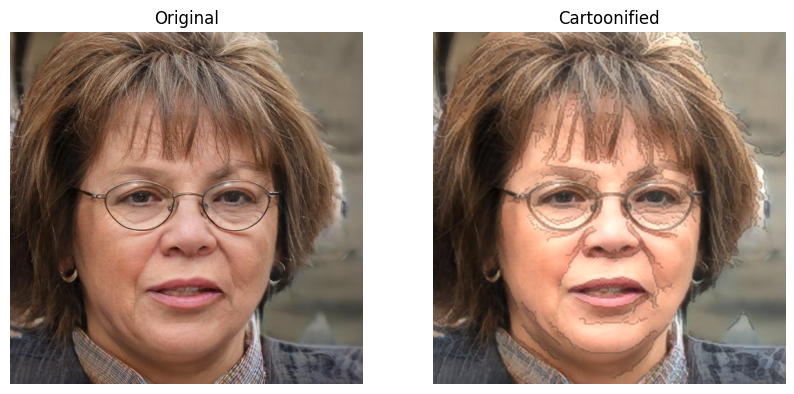

In [115]:
import os
import random

# Set your base dataset directory (update if needed)
base_dir = r"C:\Deep Learning Tasks\CNN\CARTOON\cartoon_dataset"

# Collect all images from the folder (you can point to 'train/train_image' or any image folder)
image_dir = os.path.join(base_dir, "train", "train_image")

# Get a list of image file paths
valid_exts = (".jpg", ".jpeg", ".png", ".bmp")
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(valid_exts)]

# Pick one random image
if not image_files:
    print("❌ No images found in the directory! Please check the path.")
else:
    test_image_path = random.choice(image_files)
    print(f"🖼️ Testing with random image: {os.path.basename(test_image_path)}")

    # Cartoonify the random image
    cartoon_result = cartoonify_image(model, test_image_path)
